# Feature Extraction through Autoencoder

### Unzipping the zip folder containing the images

In [1]:
path_to_zip_file = 'frames_162_relevant_v2.zip'
directory_to_extract_to = 'Relevant Data'

import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)


In [2]:
path_to_zip_file = 'frames_182_relevant.zip'
directory_to_extract_to = 'Relevant Data'

import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)


### Merge the two folders

In [6]:
import os, shutil

def mergefolders(root_src_dir, root_dst_dir):
    for src_dir, dirs, files in os.walk(root_src_dir):
        dst_dir = src_dir.replace(root_src_dir, root_dst_dir, 1)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        for file_ in files:
            src_file = os.path.join(src_dir, file_)
            dst_file = os.path.join(dst_dir, file_)
            if os.path.exists(dst_file):
                os.remove(dst_file)
            shutil.copy(src_file, dst_dir)
            
mergefolders('Relevant Data_182/frames_182_relevant_v2', 'Relevant Data/frames_162_relevant_v2')

### Splitting the folder of images into train and test

In [2]:
import shutil, os
import numpy as np
# # Creating Train / Val / Test folders (One time use)
root_dir = 'Relevant Data'
classes_dir = ['/frames_162_relevant_v2']

train_ratio = 0.80
test_ratio = 0.20

for cls in classes_dir:
    os.makedirs(root_dir +'/train' + cls)
    #os.makedirs(root_dir +'/val' + cls)
    os.makedirs(root_dir +'/test' + cls)


    # Creating partitions of the data after shuffeling
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames), 
                                                             [int(len(allFileNames)* 0.8)])

    train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
    #val_FileNames = [src + '/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    #print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir + '/train')

    #for name in val_FileNames:
       # shutil.copy(name, root_dir + '/val')

    for name in test_FileNames:
        shutil.copy(name, root_dir + '/test')

Total images:  33027
Training:  26421
Testing:  6606


### Load the train and test images from the respective folders

In [3]:
import os
import cv2

def load_images_from_folder(path):
    images = []
    
    for filename in os.listdir(path):
        if filename.endswith(".png"):
            img = cv2.imread(os.path.join(path,filename))  #Reading all the images
            img = img[10:60, 10:60]  #Resizing all the images to relevant size
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Converting all the images to gray scale
            
            if img is not None:
                images.append(img)
    return images

train_images = load_images_from_folder('Relevant Data/train')
test_images = load_images_from_folder('Relevant Data/test')

In [7]:
np.array(train_images).shape

(26421, 50, 50)

In [10]:
np.array(test_images).shape

(6606, 50, 50)

### Model definition

In [11]:
## Convolutional autoencoder

import keras
from keras import layers
import tensorflow as tf

input_layer = keras.Input(shape=(2500,)) # 50x50 image


## encoding architecture
encode_layer1 = layers.Dense(1500, activation='relu')(input_layer)
encode_layer2 = layers.Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = layers.Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = layers.Dense(10, activation='sigmoid',name = 'encoder')(encode_layer3)



## decoding architecture
decode_layer1 = layers.Dense(500, activation='relu')(latent_view)
decode_layer2 = layers.Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = layers.Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = layers.Dense(2500)(decode_layer3)

autoencoder = keras.Model(input_layer, output_layer)

# autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error') 
autoencoder.compile(optimizer='adam', loss='mse')


In [12]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2500)]            0         
_________________________________________________________________
dense (Dense)                (None, 1500)              3751500   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
encoder (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_3 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_4 (Dense)              (None, 1000)             

In [13]:
encoder_model = keras.Model(inputs = autoencoder.input,
                        outputs = autoencoder.get_layer(name = 'encoder').output)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

### Flatten the 50 x 50 images 

In [15]:
import numpy as np

x_train, x_test = np.array(train_images), np.array(test_images)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 50, 50, 1))
x_test = np.reshape(x_test, (len(x_test), 50, 50, 1))

n_images_test,_,_,_ = x_test.shape
n_images_train,_,_,_ = x_train.shape

n_images_test

x_test = x_test.reshape(n_images_test, 2500, 1)
x_train = x_train.reshape(n_images_train, 2500, 1)

In [16]:
x_test.shape

(6606, 2500, 1)

In [17]:
x_train.shape

(26421, 2500, 1)

### Train the autoencoder

In [18]:
from keras.callbacks import TensorBoard
#mse vs number of epoch (50-100)
#plot mse for train and validation. both should converge
#if the asymptote doesnt converge then make complex model
model_fit = autoencoder.fit(x_train, x_train,
                epochs = 100,
                batch_size = 128,
                shuffle = True,
                validation_data = (x_test, x_test),
                callbacks = [TensorBoard(log_dir = '/tmp/autoencoder'), early_stopping])


Epoch 1/100
  1/207 [..............................] - ETA: 0s - loss: 0.0034WARNING:tensorflow:From /Users/Armi/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
207/207 [==============================] - 35s 167ms/step - loss: 2.9625e-04 - val_loss: 7.6940e-05
Epoch 2/100
207/207 [==============================] - 50s 239ms/step - loss: 6.3734e-05 - val_loss: 5.2161e-05
Epoch 3/100
207/207 [==============================] - 43s 206ms/step - loss: 4.4746e-05 - val_loss: 4.0018e-05
Epoch 4/100
207/207 [==============================] - 49s 236ms/step - loss: 3.1549e-05 - val_loss: 2.1149e-05
Epoch 5/100
207/207 [==============================] - 39s 186ms/step - loss: 2.1020e-05 - val_loss: 1.7271e-05
Epoch 6/100
207/207 [==============================] - 38s 181ms/step - loss: 1.66

### Visualize the reconstructed inputs and the encoded representations

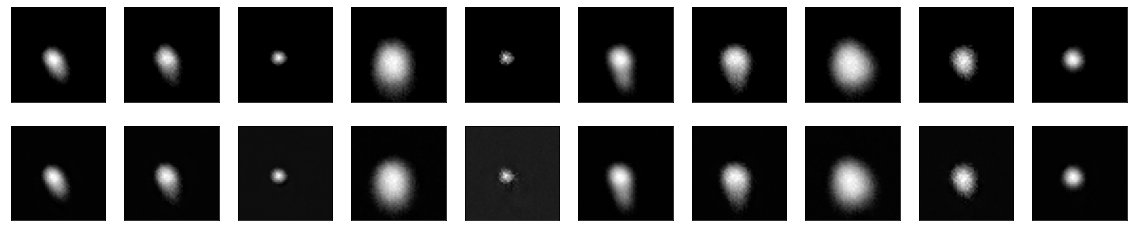

In [19]:
import matplotlib.pylab as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(50, 50))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(50, 50))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Predict the pixel values of images at the bottle neck (after encoder)

In [20]:
#Loading all the images from the relevant folder using the function defined earlier
relevant_images = load_images_from_folder('Relevant Data/frames_162_relevant_v2')

#Reshaping the pixel values of all the loaded images
relevant_images = np.reshape((np.array(relevant_images).astype('float32') / 255.) , (len(relevant_images), 2500, 1))

#Predicting the features at the bottle neck using the encoder_model defined earlier
predicted_features_all = encoder_model.predict(relevant_images)

In [21]:
predicted_features_all.shape

(33027, 10)

In [22]:
reshaped_images_all = [b.reshape((-1)) for b in predicted_features_all]
np.array(reshaped_images_all).shape

(33027, 10)

### Grab the title of file names in the image folder

In [24]:
import glob, re

files = glob.glob('Relevant Data/frames_162_relevant_v2/*.png')
a = []
for file in files:
    fName = re.findall(r'([^\/]+)$', file)
    a.append(fName)

flat_list = []
for sublist in a:
    for item in sublist:
        flat_list.append(item)       


### Create dataframe for all the images in the folder and their respective features

In [25]:
import pandas as pd
column_label = []
num = np.arange(1, 14074, 1)

for i in range(len(flat_list)):
    label = flat_list[i]
    column_label = np.append(column_label, label)
    
df1 = pd.DataFrame(np.array(reshaped_images_all).T, columns = column_label)
df1 = df1.T


In [26]:
df1.to_csv('new_features_autoencoder_182_and_162.csv')
df1

,0,1,2,3,4,5,6,7,8,9
video161_frame662134.png,0.255162,0.245263,0.223576,0.249077,0.319740,0.155845,0.461245,0.169006,0.357514,0.231576
video161_frame655798.png,0.440594,0.488265,0.410015,0.458151,0.471854,0.423319,0.328515,0.283595,0.373401,0.452606
video161_frame644695.png,0.366693,0.497431,0.370108,0.441240,0.397562,0.442910,0.250769,0.415994,0.382741,0.488046
video161_frame655940.png,0.380915,0.496629,0.266465,0.498488,0.361204,0.224087,0.380120,0.329619,0.408757,0.379090
video161_frame664545.png,0.312560,0.393383,0.275128,0.274985,0.275334,0.248545,0.308189,0.276191,0.351740,0.356569
...,...,...,...,...,...,...,...,...,...,...
video181_frame295904.png,0.384612,0.514997,0.566778,0.455904,0.475188,0.564979,0.222736,0.477982,0.266922,0.519726
video161_frame655959.png,0.520380,0.385288,0.312217,0.465830,0.381034,0.347372,0.418242,0.189612,0.434343,0.398856
video161_frame663233.png,0.383745,0.336194,0.343801,0.307135,0.305072,0.273043,0.318665,0.246479,0.358543,0.398736
video161_frame644854.png,0.371755,0.490334,0.395233,0.393618,0.403371,0.496803,0.237250,0.358582,0.363974,0.471749
